In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

collocation_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
from interpolation import BarycentricInterpolation

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d
from data_generation import generate_ode_data

collocation_path = os.path.abspath(os.path.join('..', '04_energy_consumption_reformat'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
import nn_pyomo

In [2]:
# pyomo
import importlib
import nn_pyomo_admm

importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

### Prepare data for decomposition
* Starting with the toy dataset to ensure the approach works

In [66]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10*2
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

In [69]:
decomposition = False
#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
if decomposition:
    weights_ho_cheb = compute_weights(t_ho_cheb[:int(N/2)])
    D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb[:int(N/2)], weights_ho_cheb))
else: 
    weights_ho_cheb = compute_weights(t_ho_cheb)
    D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [92]:
L = 0
R = 200

importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo

# prepare data
ys = np.atleast_2d(y_noisy_ho_cheb[L:R,0]).T
ts = np.array(t_ho_cheb)[L:R]
Xs = np.atleast_2d(y_noisy_ho_cheb[L:R,1]).T
Ds = np.array(D_ho_cheb)[L:R, L:R]

layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-7
params = {"tol":1e-7, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        
        # repeat the same for the acceptable tolerances
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, 
        #"hessian_approximation": 'limited-memory', 
        #"mu_strategy": 'adaptive', #"check_derivatives_for_naninf": 'yes',
        #'nlp_scaling_method' = 'gradient-based', # 'linear_solver'] = 'ma57',
        "max_iter": 1000}

# ----------------------------------------------------------- #
ode_model = NeuralODEPyomo(np.array(ys), # y
                        np.array(ts), # t
                        np.array(Ds),
                        
                        layer_widths, act_func = "tanh", 
                        y_init = ys, 
                        penalty_lambda_reg = 0.1, 
                        time_invariant = True,
                        extra_input = Xs, # X
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method="collocation",
                        penalty_lambda_smooth = 0.0,
                        ncp = 3
                        #discretization_scheme = "LAGRANGE-LEGENDRE",
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    55919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16321

Total number of variables............................:      281
             

Mean Absolute Error - Direct: 0.1713375333539221
Mean Absolute Error - ODE solver: 0.1749916193093785


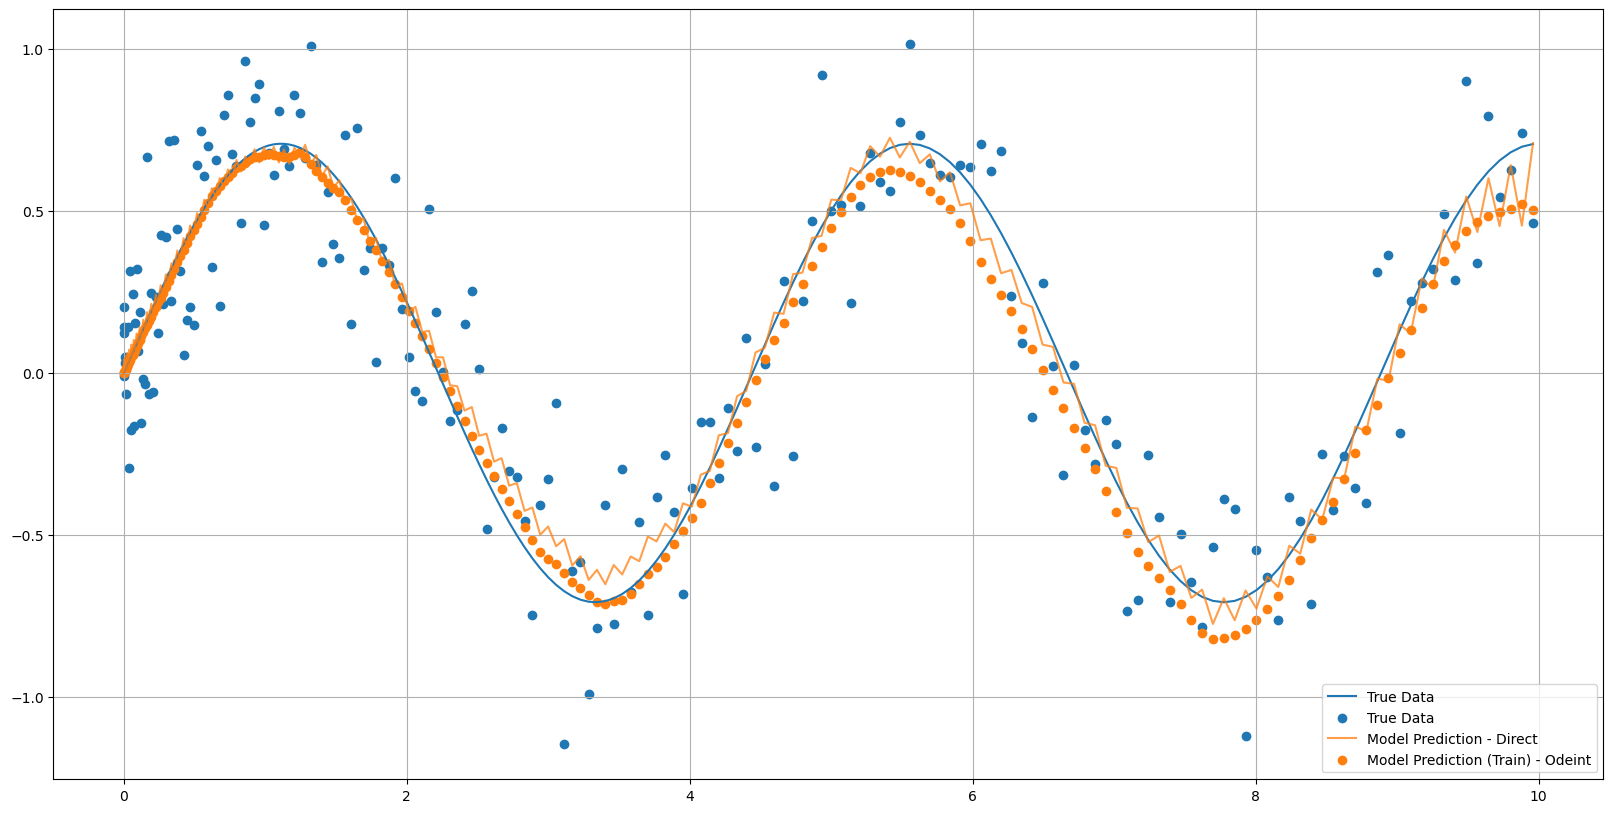

In [93]:
y0 = np.array([0.0])
t = np.array(t_ho_cheb[L:R])
y_pred = ode_model.neural_ode(y0, t, (Xs, t))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
plt.plot(t_ho_cheb[L:R], y_ho_cheb[L:R,0], label='True Data', alpha = 1)
plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)

plt.plot(t_ho_cheb[L:R], u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_ho_cheb[L:R], y_pred[:,0], label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

We are considering problem decomposition for a task that requires Chebyshev node, spacing; </br>
The nodes have to be regenerated between the batches, because splitting half way does not produce good results

---

## Van Der Pol

In [130]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb, y_vdp_cheb, y_noisy_vdp_cheb, true_derivatives_vdp_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time*2, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb = np.array(jnp.squeeze(y_noisy_vdp_cheb))
t_vdp_cheb = np.array(jnp.squeeze(t_vdp_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb = compute_weights(t_vdp_cheb)
D_vdp_cheb = np.array(lagrange_derivative(t_vdp_cheb, weights_vdp_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp_cheb, y_test_vdp_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_vdp_cheb, estimated_solution_vdp_cheb = collocate_data(y_noisy_vdp_cheb, t_vdp_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [153]:
L, R = 0, 100

importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo

# prepare data
ys = np.atleast_2d(y_noisy_vdp_cheb[L:R,0]).T
ts = np.array(t_vdp_cheb)[L:R]
Xs = np.atleast_2d(y_noisy_vdp_cheb[L:R,1]).T
Ds = np.array(D_vdp_cheb)[L:R, L:R]

layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-7
params = {"tol":1e-7, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 1000}

# ----------------------------------------------------------- #
ode_model = NeuralODEPyomo(
                        np.array(ys), # y
                        np.array(ts), # t
                        np.array(Ds),
                        
                        layer_widths, act_func = "tanh", 
                        y_init = np.array(estimated_solution_vdp_cheb[0]), 
                        penalty_lambda_reg = 0.1, 
                        time_invariant = True,
                        extra_input = Xs, 
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method="collocation",
                        penalty_lambda_smooth = 0.0,
                        ncp = 3
                        #discretization_scheme = "LAGRANGE-LEGENDRE",
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    17919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8221

Total number of variables............................:      181
             

Mean Absolute Error - Direct: 0.13579514000075135
Mean Absolute Error - ODE solver: 0.08853139505920236


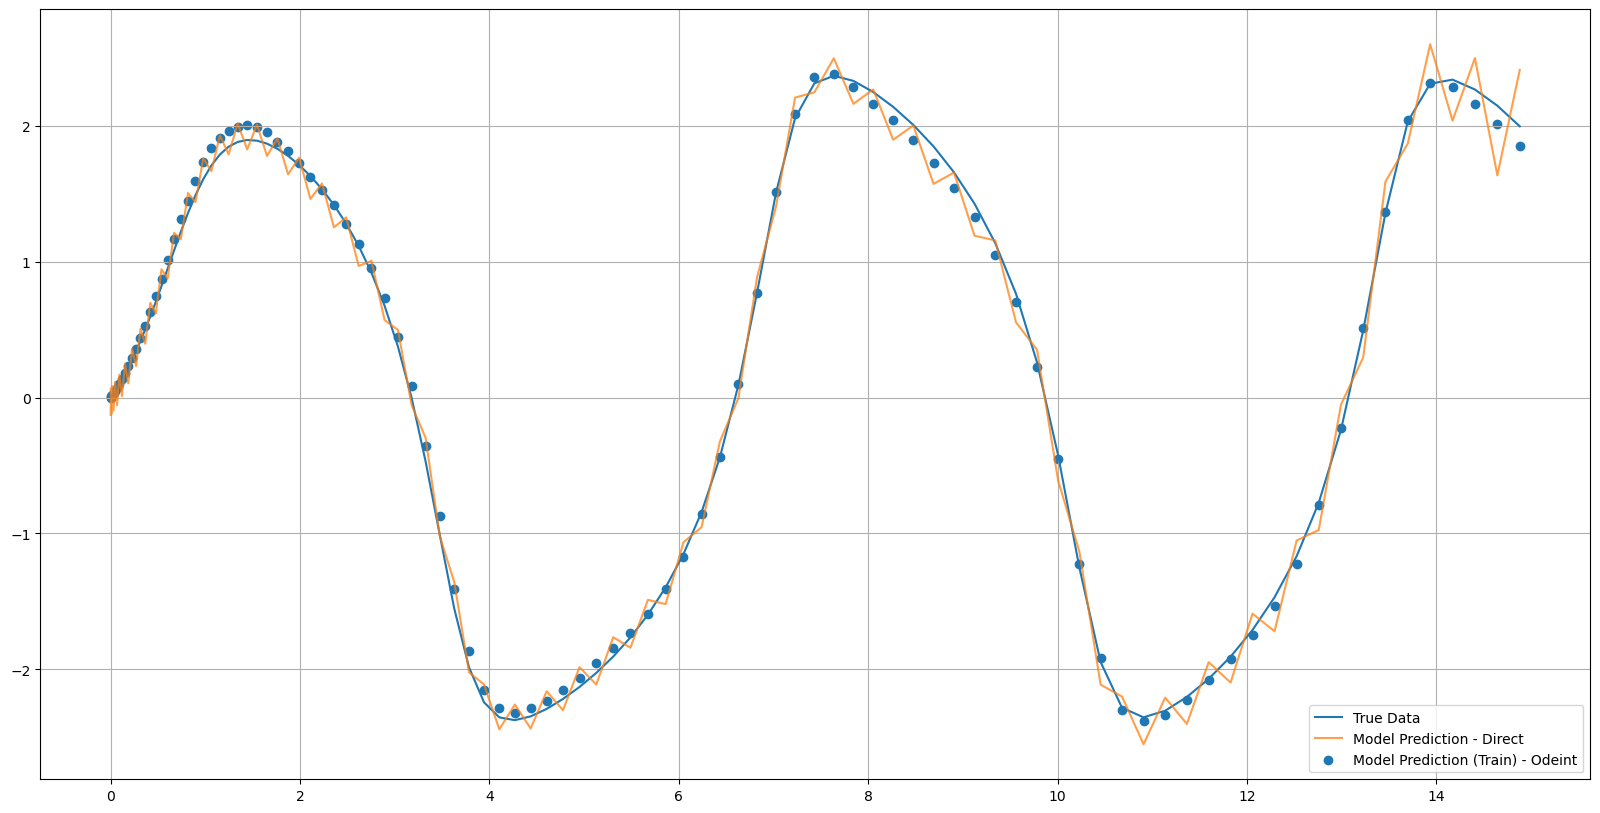

In [136]:
y0 = np.array([0.0])
t = np.array(t_vdp_cheb[L:R])
y_pred = ode_model.neural_ode(y0, t, (Xs, t))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
plt.plot(t_vdp_cheb[L:R], y_vdp_cheb[L:R,0:1], label='True Data', alpha = 1)
#plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)

plt.plot(t_vdp_cheb[L:R], u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_vdp_cheb[L:R], y_pred[:,0], label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

* The quality of the solutions deteriorates when the node spacing does not follow Chebyshev nodes;
* Hence, the points will have to be regenerated when conducting decomposition;

Original data points: 100
New data points: 289


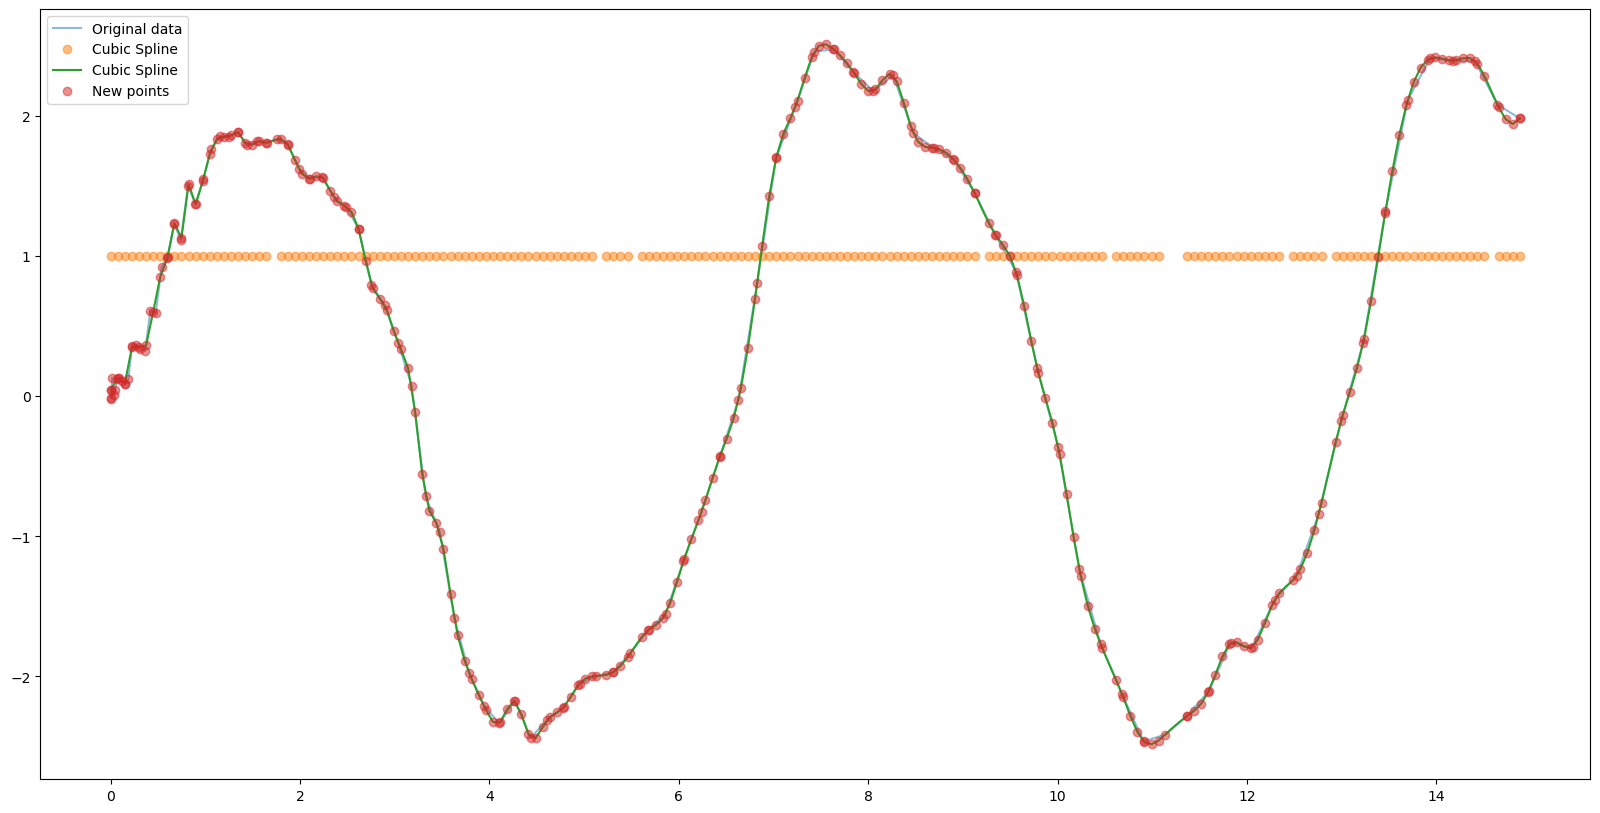

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d

ys_smooth = gaussian_filter1d(ys, sigma = 5000)

cs_smooth = CubicSpline(ts, ys_smooth)

def second_derivative(cs, ts):
    return cs(ts, 2)

# Evaluate the second derivative at a fine grid
x_fine = np.linspace(0, max(ts), 200)
second_deriv = second_derivative(cs_smooth, x_fine)

# Threshold for high second derivative
threshold = 0.8

# Identify regions with high second derivative
high_deriv_indices = np.where(np.abs(second_deriv) > threshold)[0]
high_deriv_x = x_fine[high_deriv_indices]

x_new = np.sort(np.concatenate((ts, high_deriv_x)))

cs = CubicSpline(ts, ys)
y_new = cs(x_new)

print(f"Original data points: {len(ts)}")
print(f"New data points: {len(x_new)}")

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='Original data', alpha = 0.5)
plt.plot(high_deriv_x, np.ones_like(high_deriv_x), 'o',label='Cubic Spline', alpha = 0.5)
plt.plot(x_fine, cs_smooth(x_fine), label='Cubic Spline')
plt.plot(x_new, y_new, 'o', label='New points', alpha = 0.5)
plt.legend()
plt.show()

* Since Chebyshev Node regeneration as a part of a Pyomo model set up involves extra step, <br>
the initial iteration will look at using the `dae` library to obtain the proof of concept;

#### `1)` Regenerate data but equally spaced

In [214]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 800
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time*2, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t_vdp, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [228]:
weights_vdp_cheb = compute_weights(t_vdp[400:800])
D_vdp_cheb = np.array(lagrange_derivative(t_vdp[400:800], weights_vdp_cheb))

* Is the first derivative matrix shared?

In [250]:
L, R = 0, 400

import nn_pyomo_dae
importlib.reload(nn_pyomo_dae)
NeuralODEPyomo = nn_pyomo_dae.NeuralODEPyomo

# prepare data
ys = np.atleast_2d(y_noisy_vdp[L:R, 0]).T
ts = np.array(t_vdp)[L:R]
Xs = np.atleast_2d(y_noisy_vdp[L:R, 1]).T

layer_widths = [2, 20, 1]

tol = 1e-7
params = {"tol":1e-7, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 1000}

# ----------------------------------------------------------- #
ode_model = NeuralODEPyomo(
                        np.array(ys), # y 
                        np.array(ts), # t
                        np.array(None), # D
                        
                        layer_widths, act_func = "tanh", 
                        # y_init = np.array(estimated_solution_vdp[0]), 
                        y_init = None,
                        penalty_lambda_reg = 0.1, 
                        time_invariant = True,
                        extra_input = Xs, 
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method="pyomo",
                        penalty_lambda_smooth = 0.0,
                        ncp = 3
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105336
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    97159

Total number of variables............................:     2476
             

* `D (L)` is the derivative matrix of Lagrange polynomials evaluated at
the collocation points

Mean Absolute Error - Direct: 0.07982646438557257
Mean Absolute Error - ODE solver: 0.08419191267835675


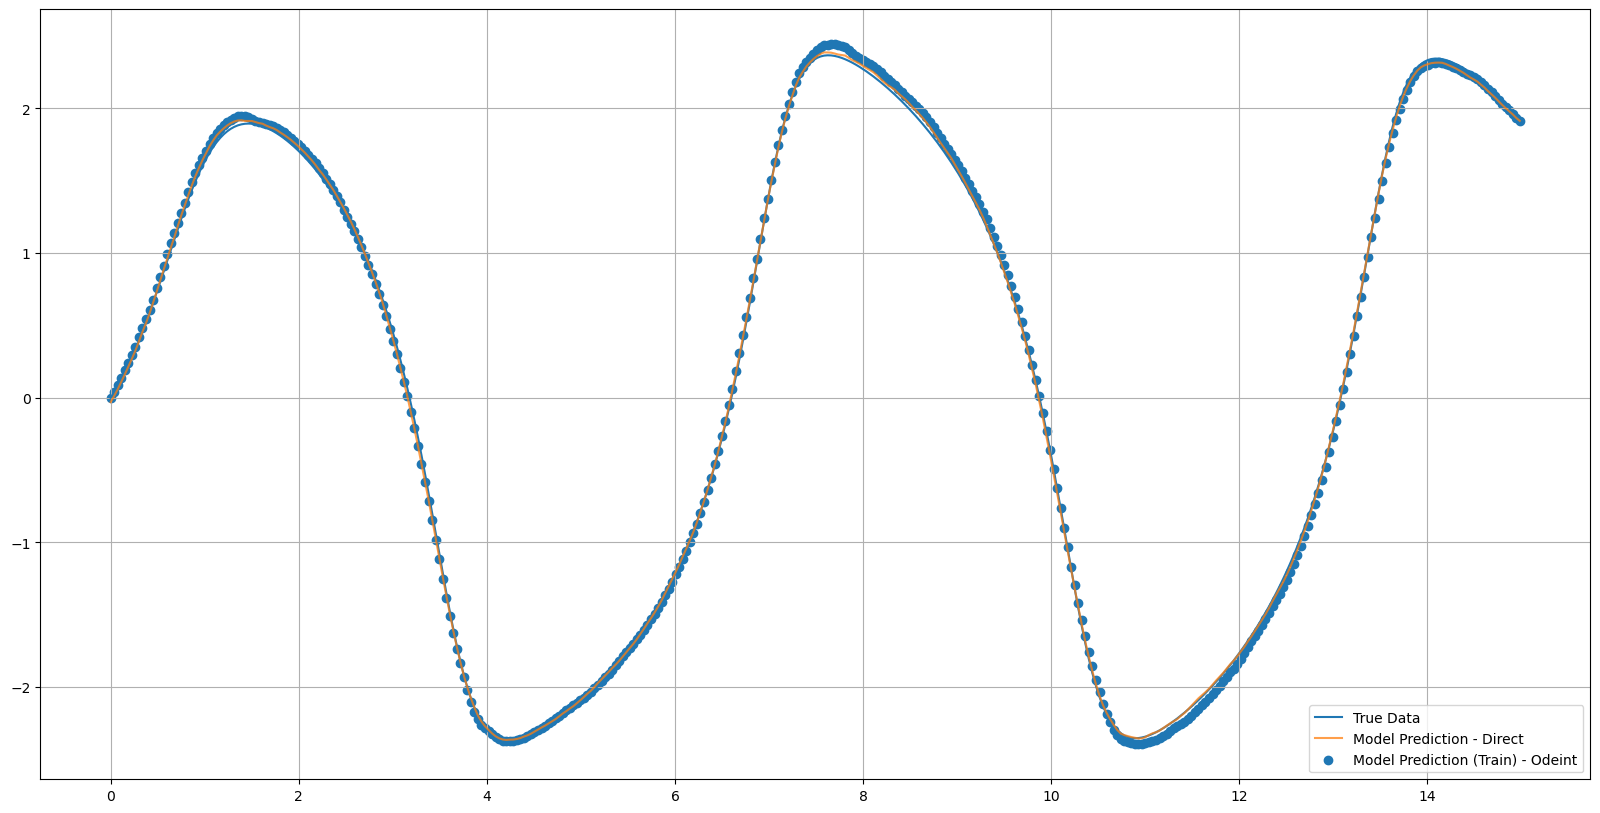

In [251]:
y0 = jnp.array([0.0])
t = jnp.array(t_vdp[L:R])
y_pred = ode_model.neural_ode(y0, t, (Xs, t))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

plt.figure(figsize=(20, 10))
plt.plot(t_vdp[L:R], y_vdp[L:R,0:1], label='True Data', alpha = 1)
# plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)

plt.plot(t_vdp[L:R], u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_vdp[L:R], y_pred[:,0], label='Model Prediction (Train) - Odeint')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()